# Annotation parser
This notebook is used to parse the CVAT annotation files and save the cropped images based on the annotations.  
The annotation files should be saved in the `annotations` folder, and the GPR images should be saved in the `unprocessed_images` folder.  
The format of the annotation files is `*.zip`, and the format of the GPR images is `*.JPG`.

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
import zipfile

## Unzip the exported dataset from CVAT
First create a `annotations` folder in the `data_preprocessing` folder, and store the exported dataset in the `annotations` folder.  
This code will unzip the exported annotation in the `annotations` folder.
Set the `zipfile_name` variable to the name of the dataset.

In [2]:
# Parameters Setting

zipfile_name = '3rdDataset20230420'

# ==================================================

with zipfile.ZipFile(f'annotations/{zipfile_name}.zip', 'r') as zf:
    if not os.path.exists(f'annotations/{zipfile_name}'):
        os.makedirs(f'annotations/{zipfile_name}')

    zf.extractall(f'annotations/{zipfile_name}')

## Label Box Extraction
`def image_names_parser(path)` -> return all image names from the annotations  
`def labels_parser(path, image_name)` -> return label boxs of corresponding image

test: check if the box is in the right place


In [3]:
def image_names_parser(path):
    tree = ET.parse(f'{path}/annotations.xml')
    root = tree.getroot()
    image_names = []
    for image in root.findall('image'):
        image_names.append(image.get('name'))
    return image_names

def labels_parser(path, image_name):
    tree = ET.parse(f'{path}/annotations.xml')
    root = tree.getroot()

    labels = {}
    for i, label in enumerate(root.iter('label')):
        labels[label.find('name').text] = i

    image_node = None
    for image in root.findall('image'):
        if image.get('name') == image_name:
            image_node = image

    boxs = []
    coordinates = ['ytl', 'xtl', 'ybr', 'xbr']
    for i in range(len(labels)):
        boxs.append([])
    for box in image_node.findall('box'):
        points = []
        for coordinate in coordinates:
            points.append(int(box.get(coordinate).split(".")[0]))
        boxs[labels[box.get('label')]].append(points)

    return boxs

## Check if the annotations is shown as they are on CVAT
Set the index of images and the feature type in the CVAT annotations.  
This code will show the image with the label box on it.

Flag of the feature type
- small strong hyperbola: 0
- small weak hyperbola: 1
- noise: 2
- large strong hyperbola: 3
- large weak hyberbola: 4
- no feature: 5

ARR7_350_230324__001 P_31111111_processed.JPG


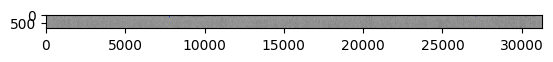

In [4]:
# Parameters Setting

index = 0   # image index in the annotation file
flag = 0    # label index in the annotation file

# ==================================================

test_image = image_names_parser(f'annotations/{zipfile_name}')[index]
boxs = labels_parser(f'annotations/{zipfile_name}', test_image)

print(test_image)
img = cv2.imread(f'processed/{test_image}')
color = np.array([3, 67, 223])
box_width = 3
for box in boxs[flag]:
    img[box[0] - box_width:box[0] + box_width, box[1]:box[3], :] = np.ones_like(img[box[0] - box_width:box[0] + box_width, box[1]:box[3], :]) * color
    img[box[2] - box_width:box[2] + box_width, box[1]:box[3], :] = np.ones_like(img[box[2] - box_width:box[2] + box_width, box[1]:box[3], :]) * color
    img[box[0]:box[2], box[1] - box_width:box[1] + box_width, :] = np.ones_like(img[box[0]:box[2], box[1] - box_width:box[1] + box_width, :]) * color
    img[box[0]:box[2], box[3] - box_width:box[3] + box_width, :] = np.ones_like(img[box[0]:box[2], box[3] - box_width:box[3] + box_width, :]) * color

plt.imshow(img)
plt.show()

In [5]:
def check_out_of_box(sliding_window, box):
    if sliding_window[2] < box[0] or sliding_window[0] > box[2]:
        return True
    if sliding_window[3] < box[1] or sliding_window[1] > box[3]:
        return True
    return False

def check_box(sliding_window, box, overlapping):
    if check_out_of_box(sliding_window, box):
        return False
    
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    overlap_area = (min(sliding_window[2], box[2]) - max(sliding_window[0], box[0])) * (min(sliding_window[3], box[3]) - max(sliding_window[1], box[1]))
    if overlap_area / box_area < overlapping:
        return False    
    
    return True

## Crop the images based on the annotations
`crop_image` will save the cropped image in the `unprocessed_images/cropped` folder.

In [6]:
def crop_image(save_path, zipfile_name, image_index, image_name, image_start, boxs, overlapping, sliding_window_size=200, step=40):
    img = cv2.imread(f'{save_path}/{image_name}')
    feature_types = ['small strong hyperbola', 'small weak hyperbola', 'noise', 'large strong hyperbola', 'large weak hyberbola', 'no feature']
    image_shape = img.shape
    print('image shape:', image_shape)
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size - image_start[1]) / step)

    no_feature_index = len(feature_types) - 1
    cropped_image_type = np.ones((height, width)) * no_feature_index
    for k, box_list in enumerate(boxs):
        for box in box_list:
            box_index = []
            for i, b in enumerate(box):
                if i % 2 == 0:
                    box_index.append((b - image_start[0]) / step)     
                else:
                    box_index.append((b - image_start[1]) / step)
            start = [math.floor(box_index[0]), math.floor(box_index[1])]
            end = [math.ceil(box_index[2] + 1), math.ceil(box_index[3] + 1)]
            for j in range(max(start[0] - int(sliding_window_size/step), 0), min(end[0], height)):
                for i in range(max(start[1] - int(sliding_window_size/step), 0), min(end[1], width)):
                    if cropped_image_type[j, i] == no_feature_index and check_box([j, i, j + int(sliding_window_size/step), i + int(sliding_window_size/step)], box_index, overlapping):
                        cropped_image_type[j, i] = k
    
    # create folders for cropped images
    for i in range(len(feature_types)):
        if not os.path.exists(f'{save_path}/cropped/{sliding_window_size}_{step}/{zipfile_name}/{image_index}/{i}'):
            os.makedirs(f'{save_path}/cropped/{sliding_window_size}_{step}/{zipfile_name}/{image_index}/{i}')
    # output cropped images
    for j in range(height):
        count = [0] * len(feature_types)
        for k in range(len(count)):
            for path in os.listdir(f'{save_path}/cropped/{sliding_window_size}_{step}/{zipfile_name}/{image_index}/{k}'):
                if path.startswith(f'{j * step}_'):
                    image_num = int(path.split(".jpg")[0].split("_")[1])
                    count[k] = max(count[k], image_num)

        for i in range(width):
            sliding_window = [image_start[0] + j * step, image_start[1] + i * step, image_start[0] + sliding_window_size + j * step, image_start[1] + sliding_window_size + i * step]
            sub_img = img[sliding_window[0]:sliding_window[2], sliding_window[1]:sliding_window[3]]
            feature_type = int(cropped_image_type[j, i])
            cv2.imwrite(f'{save_path}/cropped/{sliding_window_size}_{step}/{zipfile_name}/{image_index}/{feature_type}/{j * step}_{count[feature_type]}.jpg', sub_img)
            count[feature_type] += 1

    print(f'Finished generating images')

## Set the save path of cropped images
The cropped image save in the processed directory in default.

### Parameter
- save_path: default in 'processed'
- flag: feature type. If all kind of feature is required, run through flag 0-5
- sliding_window_size: size of the cropped images. 200 x 200 pixels in default
- step: step of sliding window. 100 pixels in default
- overlapping: acceptance rate of overlapping of sliding windows and feature box. 0.8 in default, which means that sliding window covers above 80% of feature box

Flag of the feature type
- small strong hyperbola: 0
- small weak hyperbola: 1
- noise: 2
- large strong hyperbola: 3
- large weak hyberbola: 4
- no feature: 5

In [8]:
# Parameters Setting

save_path = 'unprocessed_images'
sliding_window_size = 200
step = 40
overlapping = 0.8   # overlapping percentage of sliding windows
# IMAGE_START excludes the left axis of the image.
# AXIS_ZERO excludes the top axis of the image. For 1st dataset and 2nd dataset, this also excludes
# the first few nano seconds of the image that receive no signal from the surface.

# Boundary constant of images
IMAGE_START = 64
AXIS_ZERO = 44     # 1st dataset, 2nd dataset: 121, 3rd dataset: 44
image_start = [AXIS_ZERO, IMAGE_START]

# ==================================================

image_names = image_names_parser(f'annotations/{zipfile_name}')
for image_index, image_name in enumerate(image_names):
    boxs = labels_parser(f'annotations/{zipfile_name}', image_name)
    image_name = image_name.replace('_processed', '')
    print(f'cropping {image_name} ...')
    crop_image(save_path, zipfile_name, image_index, image_name, image_start, boxs, overlapping, sliding_window_size=sliding_window_size, step=step)

cropping ARR7_350_230324__001 P_31111111.JPG ...
image shape: (847, 31280, 3)
Finished generating images
